In [136]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

# Project 4
1.  Consider the logistic curve
$$
f(x) = \frac{e^{\beta_0 + \beta_1x}}{1 + e^{\beta_0 + \beta_1 x}}.
$$
Plot the curve for various values of $\beta_0$ and $\beta_1$ to see how changing $\beta_0$ and $\beta_1$ impact the curve.


In [119]:
def log_func(x, B0, B1):
  num = np.exp(B0 + B1 * x)
  den = 1 + np.exp(B0 + B1 * x)
  return num / den

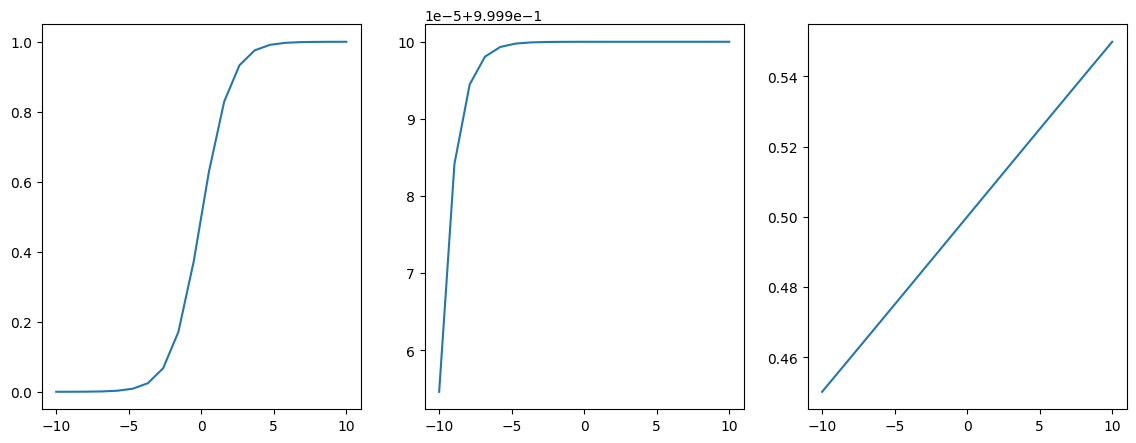

In [120]:
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

x = np.linspace(-10, 10, 20)
ax1.plot(x, log_func(x, 0, 1), label='$beta_0$=0,$beta_1$=1')
ax2.plot(x, log_func(x, 20, 1), label='$beta_0$=20,$beta_1$=1')
ax3.plot(x, log_func(x, 0, 0.02), label='$beta_0$=0,$beta_1$=0.02')

2.Consider the diamond dataset from [here](https://raw.githubusercontent.com/tidyverse/ggplot2/master/data-raw/diamonds.csv). The documentation for the dataset can be found [here](https://lbelzile.github.io/lineaRmodels/example-price-of-diamonds.html). Fit a linear model with price as the outcome, carat, cut, color and clarity as predictors. For the variables that are not numeric (cut for example), [one hot encode them](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/). Break your data into (around 25%) testing and (around 75%) training data and evaluate the square root of the mean squared error on your testing data. Use any python function library that you'd like.   

In [121]:
url = "https://raw.githubusercontent.com/tidyverse/ggplot2/master/data-raw/diamonds.csv"
diamonds = pd.read_csv(url)

In [122]:
diamonds.head(5)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [123]:
diamonds.tail(5)

,carat,cut,color,clarity,depth,table,price,x,y,z
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74
53939,0.75,Ideal,D,SI2,62.2,55.0,2757,5.83,5.87,3.64


In [124]:
# One Hot Encoding
cat_pred = ["cut", "color", "clarity"]
for pred in cat_pred:
  enc = OneHotEncoder()
  diamonds[pred] = enc.fit_transform(diamonds[pred].to_numpy().reshape((-1,1))).toarray()

# Creating Predictors and Outcome Data
X = diamonds[["carat", "cut", "color", "clarity"]]
y = diamonds["price"]

# Splitting Test and Train Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, train_size = 0.75)

# Linear Regression and Error
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
error = mean_squared_error(y_test, y_pred, squared = False)
print(f'The root mean squared error between the predicted and true diamond prices is {error:.02f}')

The root mean squared error between the predicted and true diamond prices is 1456.44


3. Consider the covid data analyzed previously. Consider a country. Let $Z_i$ be the case count for day $i$ from the first infection. Let $Y_i$ be an indicator of whether a country's case count went strictly up or down on day $i$. That is, $Y_i = 1$ if $Z_i > Z_{i-1}$ and $Y_i = 0$ if $Z_i \leq Z_{i-1}$. Consider the logit model
$$
\mathrm{logit}\{P(Y_i = 1)\} = \beta_0 + \beta_1 Z_{i-1} + \beta_2 Z_{i-2} + \beta_3 Z_{i-3} + \beta_4 Z_{i-4}
$$
In other words, does the previous four days case values predict whether or not the number of cases will go up or down tomorrow? Perform a validation in two ways. Train on the first 75% of days for a country and then consider the accuracy on the last 25%. Call this the within country forecasting accuracy. Secondly, train on 100% of the days for one country and consider the accuracy when applied to a second country. Call this the between country forecasting accuracy. In both cases, calculate the accuracy for a 0.50 threshold.


### Data Loading And Preprocessing

In [140]:
from google.colab import drive
drive.mount("gdrive/")
path = "gdrive/My Drive/Colab Notebooks/time_series_covid19_confirmed_global.csv"
covid_cases = pd.read_csv(path)

Drive already mounted at gdrive/; to attempt to forcibly remount, call drive.mount("gdrive/", force_remount=True).


In [141]:
vietnam_cases = covid_cases[covid_cases["Country/Region"] == "Vietnam"]
vietnam_cases = np.asarray(vietnam_cases.drop(["Province/State", "Country/Region", "Lat", "Long"], axis = 1)).squeeze()
vietnam_cases = vietnam_cases[np.min(np.where(vietnam_cases != 0)): vietnam_cases.size]

In [142]:
skorea_cases = covid_cases[covid_cases["Country/Region"] == "Korea, South"]
skorea_cases = np.asarray(skorea_cases.drop(["Province/State", "Country/Region", "Lat", "Long"], axis = 1)).squeeze()
skorea_cases = skorea_cases[np.min(np.where(skorea_cases != 0)): skorea_cases.size]

### Predictor & Label Methods

In [143]:
def createPredictors(arr):
  X = np.zeros((arr.size - 4, 4), dtype = int)
  for i in range(4, arr.size):
    X[i-4] = arr[i-4:i]
  return X

In [144]:
def createLabels(arr):
  y = np.zeros(arr.size - 4, dtype = int)
  for i in range(4, arr.size):
    y[i-4] = 1 if arr[i] > arr[i-1] else 0
  return y

### WITHIN COUNTRY FORECASTING ACCURACY

In [145]:
# Training and Split
X = createPredictors(vietnam_cases)
y = createLabels(vietnam_cases)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, train_size = 0.75, shuffle = False)

In [146]:
# Regression and Prediction
logit = LogisticRegression().fit(X_train, y_train)
y_pred = logit.predict(X_test)
intra_acc = accuracy_score(y_test, y_pred)
print(f'The within country forcasting accuracy is {intra_acc:.02f}')

The within country forcasting accuracy is 0.99


### BETWEEN COUNTRY FORECASTING ACCURACY

In [147]:
# Training and Split
X_train = createPredictors(vietnam_cases)
y_train = createLabels(vietnam_cases)
X_test = createPredictors(skorea_cases)
y_test = createLabels(skorea_cases)

In [148]:
# Regression and Prediction
logit = LogisticRegression().fit(X_train, y_train)
y_pred = logit.predict(X_test)
inter_acc = accuracy_score(y_test, y_pred)
print(f'The between country forcasting accuracy is {inter_acc:.02f}')

The between country forcasting accuracy is 0.99
